<a href="https://colab.research.google.com/github/sharad28/GAN/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
"""
Single Image Super-Resolution Using SRGAN
Original paper: https://arxiv.org/pdf/1609.04802.pdf
Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html
    
All images resized to 128x128 to represent HR and 32x32 to represent LR.
"""

'\nSingle Image Super-Resolution Using SRGAN\nOriginal paper: https://arxiv.org/pdf/1609.04802.pdf\nDataset from:\n    http://press.liacs.nl/mirflickr/mirdownload.html\n    \nAll images resized to 128x128 to represent HR and 32x32 to represent LR.\n'

In [39]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#Generator model
Generator basically consist of and 

1.   Residual block 
2.   Upscale block



In [40]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)    


#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [41]:

#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
"""# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py"""
from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000

#local drive location
data = "/content/drive/MyDrive/Colab Notebooks/GAN data/data"

lr_list = os.listdir(data+"/lr_images")[:n]

lr_images = []
hr_images = []
for img in lr_list:

    img_lr = cv2.imread(data+"/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   

    img_hr = cv2.imread(data+"/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


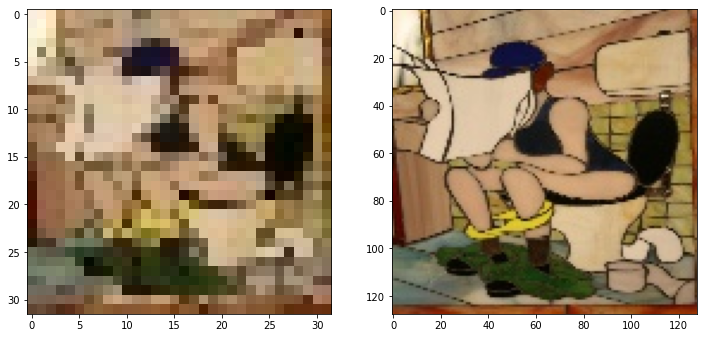

In [45]:

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
# image_number=0
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [49]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [ ]:


#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 10
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")
        generator.save("/content/drive/MyDrive/Colab Notebooks/GAN data/"+"gen_e_"+ str(e+1) +".h5")


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 64)   15616       ['input_12[0][0]']               
                                                                                                  
 p_re_lu_19 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_19[0][0]']             
                                                                                            

  1%|          | 23/3350 [01:56<4:01:46,  4.36s/it]

In [ ]:

###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()